<a href="https://colab.research.google.com/github/deinon-daemon/acidbrain/blob/main/notebook/EvaluateAccentClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Basic Requirements

In [ ]:
# speechbrain is the recommended framework for training / inference pipelines
# using https://huggingface.co/warisqr7/accent-id-commonaccent_xlsr-en-english
# and related models
!pip install torch speechbrain torchaudio
!pip install kagglehub seaborn librosa scikit-learn

## load dataset

In [ ]:
import os
import json
import kagglehub

# add your credentials file
kaggle_creds = json.loads(open("kaggle copy.json", "r").read())
os.environ["KAGGLE_USERNAME"] = kaggle_creds.get("username")
os.environ["KAGGLE_KEY"] = kaggle_creds.get("key")
kaggle_path = kagglehub.dataset_download("rtatman/speech-accent-archive")
print("Path to dataset files (Speech Accent Archive):", kaggle_path)
print("Files in directory:", os.listdir(kaggle_path))

100%|██████████| 865M/865M [00:16<00:00, 56.0MB/s]

Extracting files...


Path to dataset files (Speech Accent Archive): /root/.cache/kagglehub/datasets/rtatman/speech-accent-archive/versions/2
Files in directory: ['speakers_all.csv', 'reading-passage.txt', 'recordings']


## dataset discovery & visualization

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# inspect speaker metadata to join as "labels" to /recordings/recordings
speech_accent_file = kaggle_path + "/speakers_all.csv"
speech_accent_df = pd.read_csv(speech_accent_file)

print("Speech Accent Archive:")
speech_accent_df.info()
speech_accent_df.head()

Speech Accent Archive:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2172 non-null   float64
 1   age_onset        2172 non-null   float64
 2   birthplace       2168 non-null   object 
 3   filename         2172 non-null   object 
 4   native_language  2172 non-null   object 
 5   sex              2172 non-null   object 
 6   speakerid        2172 non-null   int64  
 7   country          2167 non-null   object 
 8   file_missing?    2172 non-null   bool   
 9   Unnamed: 9       0 non-null      float64
 10  Unnamed: 10      0 non-null      float64
 11  Unnamed: 11      1 non-null      object 
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 188.9+ KB

Speech Accent Archive (head):


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [ ]:
all_countries = set(speech_accent_df["country"].tolist())
print(f"Numbers of countries represented: {len(all_countries)}")

all_langs = set(speech_accent_df["native_language"].tolist())
print(f"Number of languages represented: {len(all_langs)}")

from_the_philippines = speech_accent_df[
    speech_accent_df["country"] == "philippines"
    ].copy()

print(f"Number of speakers from the Philippines: {len(from_the_philippines)}")

tagalog_speakers = speech_accent_df[
    speech_accent_df["native_language"] == "tagalog"
    ].copy()
print(f"Number of Tagalog Speakers represented: {len(tagalog_speakers)}")

Numbers of countries represented: 177
Number of languages represented: 214
Number of speakers from the Philippines: 23
Number of Tagalog Speakers represented: 18


In [ ]:
# plot distribution bar graph util

def plot_distribution(
    df: pd.DataFrame,
    accent_column: str,
    title: str,
    label_x: str,
    label_y: str = "Count",
    size_x: int = 50,
    size_y: int = 50,
    color: str = "dodgerblue",
    alpha_val: float = 1.0
    ):
    accent_counts = df[accent_column].value_counts()
    accent_counts.plot(kind='bar', figsize=(size_x, size_y), color=color, alpha=alpha_val)
    plt.title(title)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.xticks(rotation=45)
    plt.show()


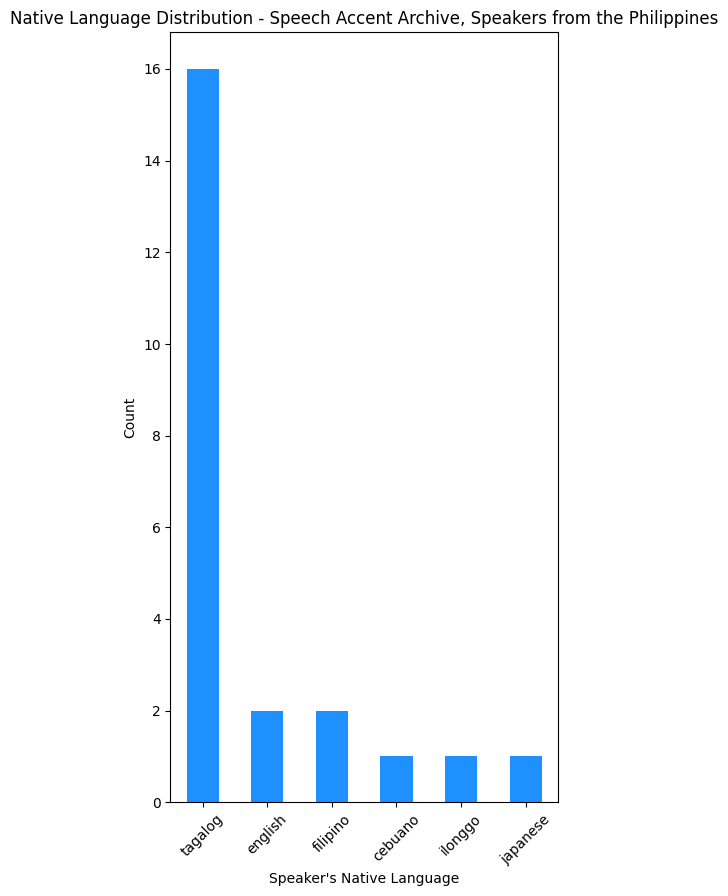

In [ ]:

plot_distribution(
    from_the_philippines,
    "native_language",
    "Native Language Distribution - Speech Accent Archive, Speakers from the Philippines",
    label_x="Speaker's Native Language",
    size_x=5,
    size_y=10
    )

In [ ]:
plot_distribution(
    speech_accent_df,
    "native_language",
    "Native Language Distribution - Speech Accent Archive",
    label_x="Speaker's Native Language",
    size_x=75,
    size_y=150
    )

In [ ]:
# define mapping of overlap countries / prediction labels between dataset & model
country_to_model_label = {
    "usa": "us",
    "england": "uk",
    "australia": "australia",
    "india": "indian",
    "canada": "canada",
    "scotland": "scotland",
    "ireland": "ireland",
    "new zealand": "newzealand",
    "philippines": "philippines",
    "signapore": "signapore",
}

## Prep, Shape, and Filter Dataset for Evaluation

In [ ]:
import os
import re
import torch
import torchaudio
import numpy as np
from tqdm import tqdm


def map_to_label(label: str):
  if label in country_to_model_label:
    return country_to_model_label[label]

# Prepare DataFrame with audio paths and labels
# Path to read the (.wav) speaker recordings
audio_dir = os.path.join(kaggle_path, "recordings/recordings")
audio_list = os.listdir(audio_dir)
data_rows = []
for audio in audio_list:
    # find the matching row in all_speakers.csv...
    match = speech_accent_df[
        speech_accent_df[
        "filename"
        ] == re.sub(r'.mp3$', '', audio)
    ].to_dict()

    data_rows.append({
        "filename": audio,
        "audio_path": os.path.join(audio_dir, audio),
        # ... and append speaker language / nationality data
        "label": map_to_label(list(match.get("country").values())[0]),
        "native_language": list(match.get("native_language").values())[0],
    })

df = pd.DataFrame(data_rows)

# Remove any NaNs
filtered_df = df[df["label"].notna()].copy()
# Remove rows tagged with labels that only occur once
filtered_df["freq"] = filtered_df.groupby("label")["label"].transform("count")
filtered_df = filtered_df[filtered_df["freq"] > 1].copy()

print(f"Row before formatting: {len(df)}")
print(f"Rows after formatting: {len(filtered_df)}")


Row before formatting: 2138
Rows after formatting: 580


In [ ]:
import os
import torch
import torchaudio
import numpy as np
from tqdm import tqdm

def process_audio(filepath, target_length=10.0, sample_rate=16000):
    """
    Processes audio files with robust error handling and validation

    Args:
        filepath (str): Path to audio file
        target_length (float): Desired length in seconds
        sample_rate (int): Target sample rate

    Returns:
        numpy.ndarray: Processed audio array
        bool: Success status
    """
    try:
        # Verify file exists and is accessible
        if not os.path.exists(filepath):
            print(f"File not found: {filepath}")
            return None, False

        # Load audio with error handling
        try:
            waveform, orig_sr = torchaudio.load(filepath, normalize=True)
        except Exception as e:
            print(f"Error loading audio {filepath}: {e}")
            return None, False

        # Validate audio data
        if waveform.nelement() == 0:
            print(f"Empty audio file: {filepath}")
            return None, False

        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Create resampler with bounds checking
        if orig_sr != sample_rate:
            try:
                resampler = torchaudio.transforms.Resample(
                    orig_sr,
                    sample_rate,
                    dtype=waveform.dtype
                )
                waveform = resampler(waveform)
            except Exception as e:
                print(f"Resampling error for {filepath}: {e}")
                return None, False

        # Calculate target samples
        target_samples = int(target_length * sample_rate)
        current_samples = waveform.size(1)

        # Handle empty or invalid audio
        if current_samples == 0:
            print(f"Invalid audio length in {filepath}")
            return None, False

        # Trim or pad
        if current_samples > target_samples:
            # Take center portion
            start = (current_samples - target_samples) // 2
            trimmed = waveform[:, start:start + target_samples]
        else:
            # Pad with zeros
            padding = target_samples - current_samples
            trimmed = torch.nn.functional.pad(waveform, (0, padding))

        # Final validation
        if trimmed.size(1) != target_samples:
            print(f"Unexpected output size for {filepath}")
            return None, False

        return trimmed.numpy().squeeze(), True

    except Exception as e:
        print(f"Unexpected error processing {filepath}: {e}")
        return None, False

def process_dataset(df, max_length=10.0, sample_rate=16000):
    """
    Process entire dataset with progress tracking and error handling

    Args:
        df (pandas.DataFrame): DataFrame with audio_path column
        max_length (float): Target length in seconds
        sample_rate (int): Target sample rate

    Returns:
        tuple: (processed_audio, valid_indices, filtered_df)
    """
    target_samples = int(max_length * sample_rate)
    processed_audio = []
    valid_indices = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        audio, success = process_audio(row['audio_path'], max_length, sample_rate)
        if success:
            processed_audio.append(audio)
            valid_indices.append(idx)

    if not processed_audio:
        raise ValueError("No valid audio files were processed")

    processed_audio = np.stack(processed_audio)
    filtered_df = df.loc[valid_indices].copy()

    return processed_audio, valid_indices, filtered_df

# Usage example:
processed_audio, valid_indices, eval_df = process_dataset(filtered_df)
print(f"Row before formatting: {len(filtered_df)}")
print(f"Rows after formatting: {len(eval_df)}")



100%|██████████| 580/580 [00:25<00:00, 22.79it/s]


Row before formatting: 580
Rows after formatting: 580


## Train / Test Split w/ WeightedRandomSampler for training optimization experiments below

In [ ]:
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split

# Stratified split
train_df, temp_df = train_test_split(eval_df, test_size=0.3, stratify=eval_df["label"])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"])


class_counts = eval_df["label"].value_counts().to_dict()
class_weights = {cls: 1./count for cls, count in class_counts.items()}
sample_weights = [class_weights[cls] for cls in train_df["country"]]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

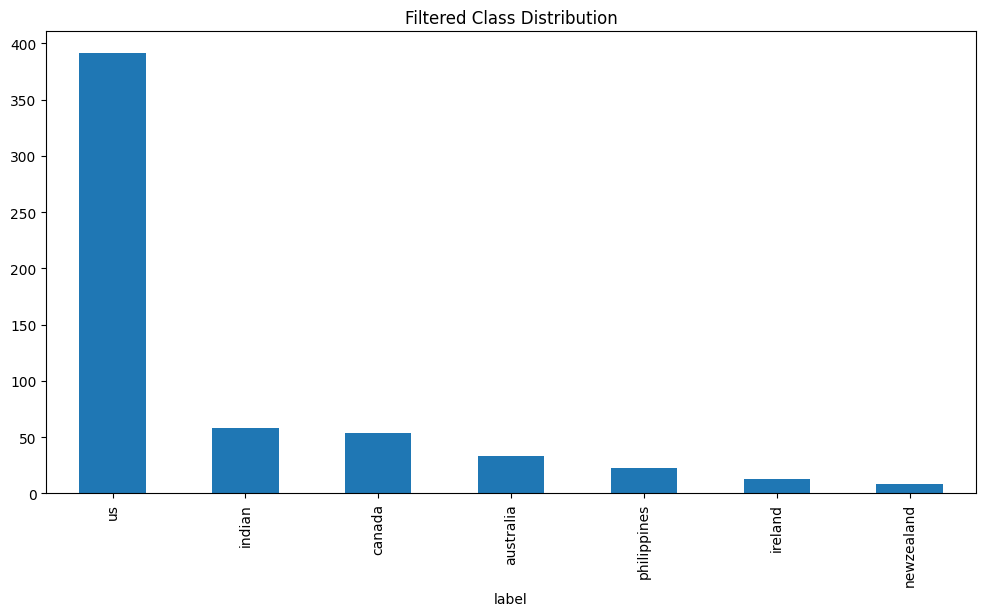

All audio clips fixed at 10.0 seconds


In [ ]:
# Check final class distribution
plt.figure(figsize=(12,6))
eval_df['label'].value_counts().plot.bar()
plt.title("Filtered Class Distribution")
plt.show()
sample_rate = 16000
# Verify audio lengths
durations = processed_audio.shape[1] / sample_rate
print(f"All audio clips fixed at {durations:.1f} seconds")

In [ ]:
num_classes = len(set(list(eval_df["label"])))
num_classes

7

## Load Model

In [ ]:
import torch
import torchaudio
from speechbrain.inference.interfaces import foreign_class
# 1. Load pretrained model with custom class & run_opts for cuda support
classifier = foreign_class(
    source="warisqr7/accent-id-commonaccent_xlsr-en-english",
    pymodule_file="custom_interface.py",
    classname="CustomEncoderWav2vec2Classifier",
    savedir="pretrained_model",
    run_opts={"device":"cuda"}  # or "cpu"
    )

hyperparams.yaml:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

custom_interface.py:   0%|          | 0.00/8.10k [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

wav2vec2.ckpt:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/66.4k [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/297 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

In [ ]:
for module in classifier.modules(): print(module)

## Inference (iterative and batched)

In [ ]:
from tqdm import tqdm
import torchaudio

def run_inference(df):
    predictions = []
    scores = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            out_prob, score, index, text_lab = classifier.classify_file(
                row['audio_path']
                )
            predictions.append(text_lab[0])
            scores.append(float(score))
        except Exception as e:
            print(f"Error processing {row['audio_path']}: {e}")
            predictions.append(None)
            scores.append(None)
    return predictions, scores

# Run inference on test set
test_df["prediction"], test_df["score"] = run_inference(test_df)
test_df = test_df.dropna()  # Remove failed predictions

100%|██████████| 580/580 [04:04<00:00,  2.37it/s]


In [ ]:


def process_df_for_batch_inference(
    df: pd.DataFrame,
    processed_audio: list,
    batch_size: int = 32
    ):
  # Batch processing with optimal chunking
  predictions = []
  scores = []
  for i in tqdm(range(0, len(processed_audio), batch_size)):
      batch = processed_audio[i:i+batch_size]
      waveforms = torch.from_numpy(batch).float()

      # Use classify_batch for optimized inference
      _, batch_scores, _, batch_preds = classifier.classify_batch(waveforms)
      predictions.extend(batch_preds)
      scores.extend(batch_scores)


  df["prediction"] = predictions
  df["score"] = [float(s) for s in scores]
  return df

test_df = process_df_for_batch_inference(test_df, processed_audio)


100%|██████████| 19/19 [01:05<00:00,  3.47s/it]


## Results, Evaluation, Confusion Matrix Visualization, Accuracy Table, etc.

In [ ]:
test_df

,filename,audio_path,label,native_language,freq,prediction,score
0,tamil5.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,indian,tamil,58,african,0.849468
2,english325.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,1.000000
4,english104.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,0.974875
7,english500.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,australia,english,33,australia,1.000000
8,english453.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,0.999599
...,...,...,...,...,...,...,...
2126,english171.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,1.000000
2128,english525.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,0.999077
2129,english273.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,1.000000
2134,english124.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,us,english,391,us,0.999944


In [ ]:
philippines_results = test_df[test_df["label"] == "philippines"]
philippines_results

,filename,audio_path,label,native_language,freq,prediction,score
103,filipino1.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,filipino,23,us,1.000000
142,tagalog6.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,philippines,0.909929
162,tagalog5.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,us,0.999974
341,filipino2.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,filipino,23,us,0.999999
344,tagalog1.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,us,0.999547
352,japanese16.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,japanese,23,us,0.999957
512,tagalog2.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,philippines,0.998789
847,tagalog12.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,us,0.999998
876,tagalog9.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,canada,0.991783
967,tagalog15.mp3,/root/.cache/kagglehub/datasets/rtatman/speech...,philippines,tagalog,23,us,0.999531


Classification Report:
              precision    recall  f1-score   support

     african       0.00      0.00      0.00         0
   australia       0.80      0.73      0.76        33
     bermuda       0.00      0.00      0.00         0
      canada       0.16      0.09      0.12        54
     england       0.00      0.00      0.00         0
      indian       1.00      0.34      0.51        58
     ireland       0.80      0.31      0.44        13
  newzealand       0.25      0.12      0.17         8
 philippines       0.40      0.09      0.14        23
    scotland       0.00      0.00      0.00         0
   singapore       0.00      0.00      0.00         0
          us       0.80      0.94      0.86       391

    accuracy                           0.73       580
   macro avg       0.35      0.22      0.25       580
weighted avg       0.74      0.73      0.71       580



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


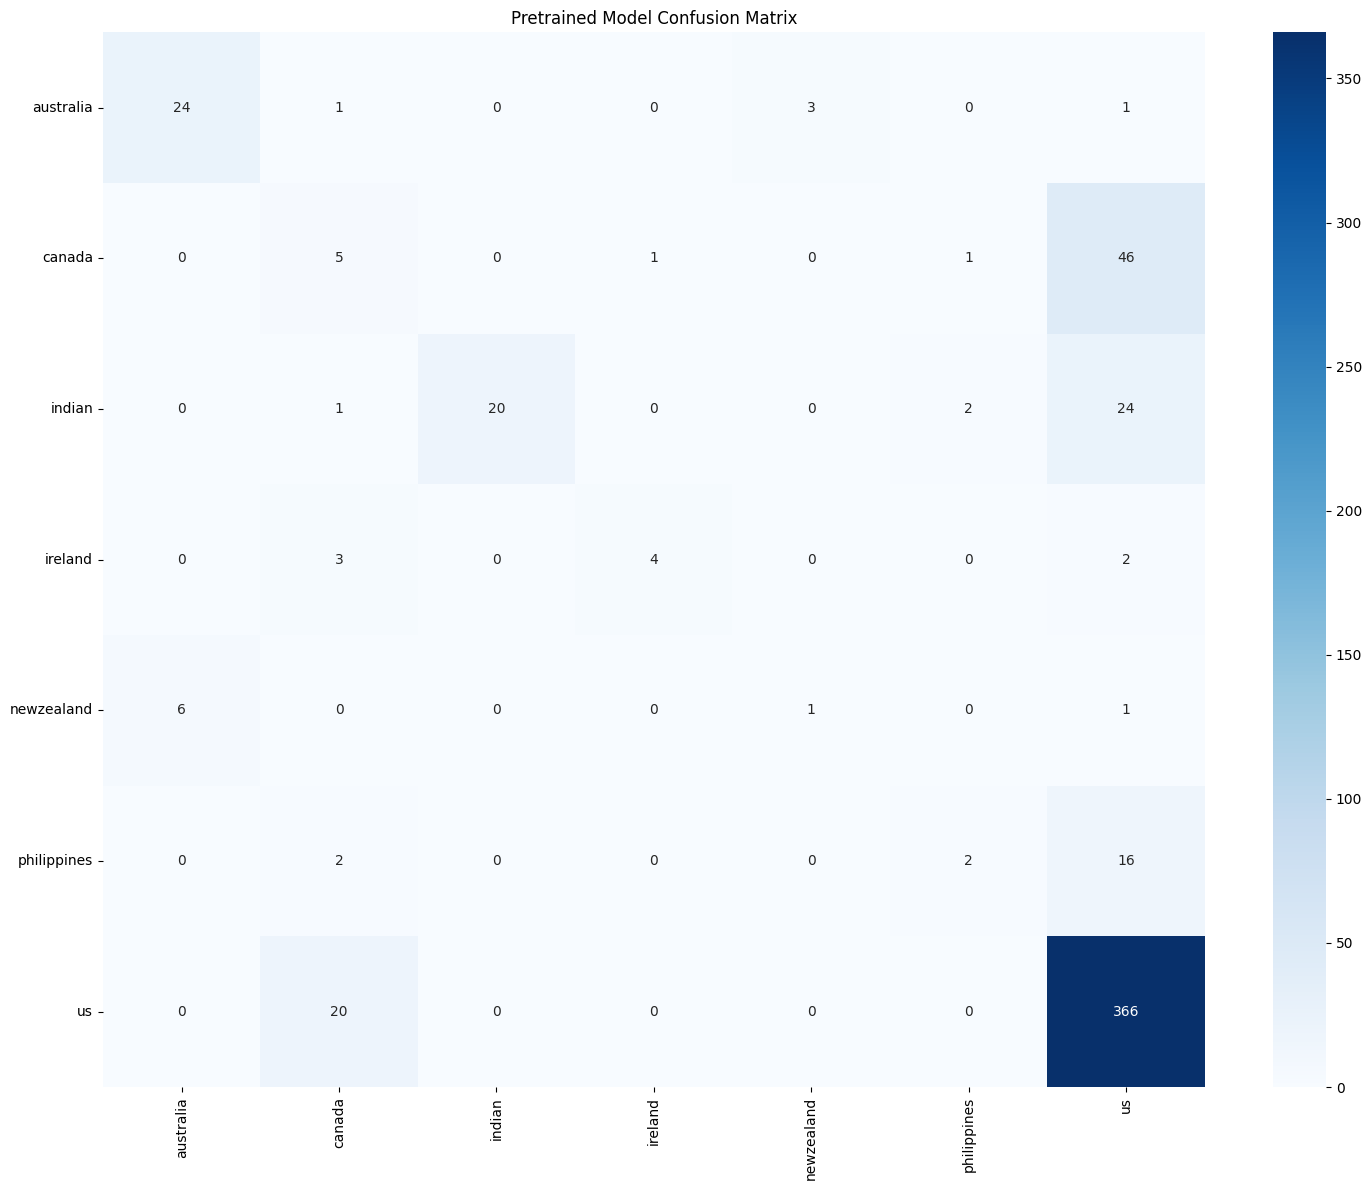


Filipino Accent Performance:
              precision    recall  f1-score   support

     bermuda       0.00      0.00      0.00         0
      canada       0.00      0.00      0.00         0
 philippines       1.00      0.09      0.16        23
   singapore       0.00      0.00      0.00         0
          us       0.00      0.00      0.00         0

    accuracy                           0.09        23
   macro avg       0.20      0.02      0.03        23
weighted avg       1.00      0.09      0.16        23



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


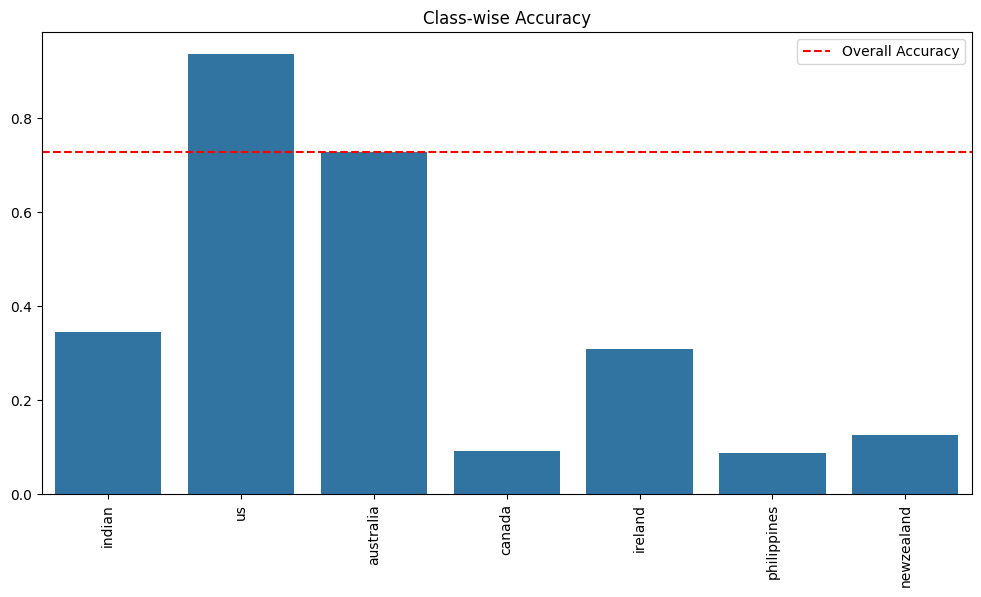

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Generate metrics
print("Classification Report:")
print(classification_report(test_df['label'], test_df['prediction']))

# Confusion Matrix
plt.figure(figsize=(15,12))
cm = confusion_matrix(test_df['label'], test_df['prediction'],
                     labels=np.unique(test_df['label']))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=np.unique(test_df['label']),
           yticklabels=np.unique(test_df['label']))
plt.title("Pretrained Model Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Filipino-specific metrics
filipino_mask = test_df['label'] == 'philippines'
print("\nFilipino Accent Performance:")
print(classification_report(
    test_df[filipino_mask]['label'],
    test_df[filipino_mask]['prediction']
    ))

# Class distribution vs accuracy
accuracy_per_class = {
    cls: np.mean(test_df[test_df['label'] == cls]['prediction'] == cls)
    for cls in test_df['label'].unique()
}

plt.figure(figsize=(12,6))
sns.barplot(x=list(accuracy_per_class.keys()),
           y=list(accuracy_per_class.values()))
plt.axhline(np.mean(test_df['label'] == test_df['prediction']),
           color='r', linestyle='--', label='Overall Accuracy')
plt.title("Class-wise Accuracy")
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
# Track accuracy per accent
accuracy_table = test_df.groupby("label")[["label","score","prediction","native_language"]].apply(
    lambda x: (x["label"] == x["prediction"]).mean()
    ).sort_values(ascending=False)

print("Accuracy by Accent:")
print(accuracy_table)

Accuracy by Accent:
label
us             0.920716
australia      0.727273
indian         0.293103
newzealand     0.250000
canada         0.074074
philippines    0.043478
ireland        0.000000
dtype: float64


## Training the model to optimize classification accuracy

In [ ]:
import logging
import os
import sys
from typing import Optional

import speechbrain as sb
import torch
import torch.nn.functional as F
import librosa
from hyperpyyaml import load_hyperpyyaml
from torch.utils.data import WeightedRandomSampler
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)

class FocalLoss(torch.nn.Module):
    """Focal Loss for handling class imbalance."""
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class EnhancedAccentID(sb.Brain):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.y_true = []
        self.y_pred = []
        self.focal_loss = FocalLoss()

    def prepare_features(self, wavs, stage):
        """Prepare features with augmentation during training."""
        wavs, lens = wavs

        if stage == sb.Stage.TRAIN and self.hparams.apply_augmentation:
            wavs_noise = self.modules.env_corrupt(wavs, lens)
            wavs = torch.cat([wavs, wavs_noise], dim=0)
            lens = torch.cat([lens, lens], dim=0)

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, lens)

        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm_input(feats, lens)
        return feats, lens

    def compute_forward(self, batch, stage):
        """Forward pass with phased training support."""
        batch = batch.to(self.device)
        feats, lens = self.prepare_features(batch.sig, stage)

        if stage == sb.Stage.TRAIN and hasattr(self, "current_phase"):
            # Phase 1: Feature adaptation (frozen encoder)
            if self.current_phase == "adaptation":
                with torch.no_grad():
                    embeddings = self.modules.embedding_model(feats)
            # Phase 2: Full fine-tuning
            else:
                embeddings = self.modules.embedding_model(feats)
        else:
            embeddings = self.modules.embedding_model(feats)

        outputs = self.modules.classifier(embeddings)
        return outputs, lens

    def compute_objectives(self, inputs, batch, stage):
        """Compute loss with focal loss and track predictions."""
        predictions, lens = inputs
        targets = batch.accent_encoded.data

        if stage == sb.Stage.TRAIN and self.hparams.apply_augmentation:
            targets = torch.cat([targets, targets], dim=0)

        # Use focal loss instead of standard cross-entropy
        loss = self.focal_loss(predictions, targets)

        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, targets, lens)
            self.y_true.append(targets.detach().cpu())
            self.y_pred.append(predictions.argmax(dim=-1).detach().cpu())

        return loss

    def on_stage_start(self, stage, epoch=None):
        """Initialize metrics and prediction trackers."""
        super().on_stage_start(stage, epoch)
        if stage != sb.Stage.TRAIN:
            self.y_true = []
            self.y_pred = []

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Enhanced stage end processing with accent-specific metrics."""
        super().on_stage_end(stage, stage_loss, epoch)

        if stage != sb.Stage.TRAIN:
            y_true = torch.cat(self.y_true)
            y_pred = torch.cat(self.y_pred)

            # Calculate per-accent recalls
            unique_accents = torch.unique(y_true)
            accent_recalls = {}

            for accent in unique_accents:
                accent_mask = y_true == accent
                if accent_mask.any():
                    recall = (y_pred[accent_mask] == y_true[accent_mask]).float().mean()
                    accent_recalls[f"accent_{accent}_recall"] = recall.item()

            # Log accent-specific metrics
            if stage == sb.Stage.VALID:
                self.hparams.train_logger.log_stats(
                    stats_meta={"epoch": epoch},
                    train_stats={"loss": self.train_loss},
                    valid_stats={**accent_recalls, "error_rate": self.error_metrics.summarize("average")}
                )

def create_weighted_sampler(dataset, accent_key="accent"):
    """Create a weighted sampler to handle class imbalance."""
    accent_list = [item[accent_key] for item in dataset.data.values()]
    class_counts = torch.bincount(torch.tensor([dataset.label_encoder.encode_label(accent) for accent in accent_list]))
    class_weights = 1. / class_counts.float()
    sample_weights = [class_weights[dataset.label_encoder.encode_label(accent)] for accent in accent_list]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def dataio_prep(hparams):
    """Enhanced data preparation with weighted sampling."""
    train_data, valid_data, test_data = sb.dataio.dataset.load_dataset(
        hparams["data_folder"],
        hparams["train_csv"], hparams["valid_csv"], hparams["test_csv"]
    )

    # Create weighted sampler for training data
    train_sampler = create_weighted_sampler(train_data)

    # Add weighted sampler to dataloader options
    hparams["train_dataloader_opts"]["sampler"] = train_sampler
    hparams["train_dataloader_opts"]["shuffle"] = False  # Disable shuffle when using sampler

    return train_data, valid_data, test_data


def get_run_opts():
    """Returns the default run options for training."""
    run_opts = {
        "debug": False,  # Set to True for debugging
        "debug_batches": 2,  # Number of batches for debugging
        "debug_epochs": 2,  # Number of epochs for debugging
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "data_parallel_backend": False,  # Set to True for multi-GPU training
        "distributed_launch": False,  # Set to True for distributed training
        "distributed_backend": "nccl",  # Backend for distributed training
        "find_unused_parameters": False,
        "jit_module_keys": None,  # Set to module names to use JIT
        "auto_mix_prec": False,  # Set to True to use automatic mixed precision
        "max_grad_norm": 5.0,  # For gradient clipping
        "nonfinite_patience": 3,  # How many times to retry if loss is non-finite
        "noprogressbar": False,  # Set to True to disable progress bar
    }
    return run_opts

run_opts = get_run_opts()
hparams_file = "hparams/hparams.yaml"

"""Main training function with phased training support."""
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin)

# Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
)

# Data preparation
run_on_main(
    prepare_common_accent,
    kwargs={
        "data_folder": hparams["data_folder"],
        "save_folder": hparams["save_folder"],
    },
)

# Create datasets
train_data, valid_data, test_data = dataio_prep(hparams)

# Initialize brain object
aid_brain = EnhancedAccentID(
    modules=hparams["modules"],
    opt_class=hparams["opt_class"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

# Phase 1: Feature Adaptation
aid_brain.current_phase = "adaptation"
for param in aid_brain.modules.embedding_model.parameters():
    param.requires_grad = False

aid_brain.fit(
    epoch_counter=2,
    train_set=train_data,
    valid_set=valid_data,
    train_loader_kwargs=hparams["train_dataloader_opts"],
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
)

# Phase 2: Full Fine-tuning
aid_brain.current_phase = "fine_tuning"
for param in aid_brain.modules.embedding_model.parameters():
    param.requires_grad = True

aid_brain.fit(
    epoch_counter=7,
    train_set=train_data,
    valid_set=valid_data,
    train_loader_kwargs=hparams["train_dataloader_opts"],
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
)

# Final evaluation
aid_brain.evaluate(
    test_data,
    min_key="error_rate",
    test_loader_kwargs=hparams["test_dataloader_opts"],
)